## Mall Customer Segmentation

Use the given customer credentials to determine which customers are suitable becoming your target customer.

The data is from membership cards which provide Customer ID, age, gender, annual income, and spending score.

Spending Score is something you assign to the customer based on your defined parameters like customer behavior and purchasing data.

The dataset is from Kaggle, please refer to:
[link](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)

### 1. Import Libraries

In [13]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# modeling
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

# scaling features
from sklearn.preprocessing import StandardScaler

# evaluation metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score

### 2. Data Loading

In [2]:
# load data
customer_data = pd.read_csv("Mall_Customers.csv")

# show first 5 lines
customer_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# check total data and data type attributes
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


#### Insight:
- there are 200 data with no missing values.
- we have numeric and categorical data.  
 a. Numeric: CustomerID, Age, Annual Income, Spending Score.
 b. Categorical: Gender

### 3. Data Cleaning
- reformat the column names: change to lowercase, remove (), and replace spaces between words by "_".

In [4]:
# change the column names to lower case
customer_data.columns = customer_data.columns.str.lower()

# replace "()" to ""
customer_data.columns = customer_data.columns.str.replace("(","")
customer_data.columns = customer_data.columns.str.replace(")","")

# change the spaces in column names to "_"ArithmeticError
customer_data.columns = customer_data.columns.str.replace(" ","_")


In [6]:
# check on dataframe
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   customerid            200 non-null    int64 
 1   gender                200 non-null    object
 2   age                   200 non-null    int64 
 3   annual_income_k$      200 non-null    int64 
 4   spending_score_1-100  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


### 4. Exploratory Data Analysis

#### a. Among The Numeric Variables

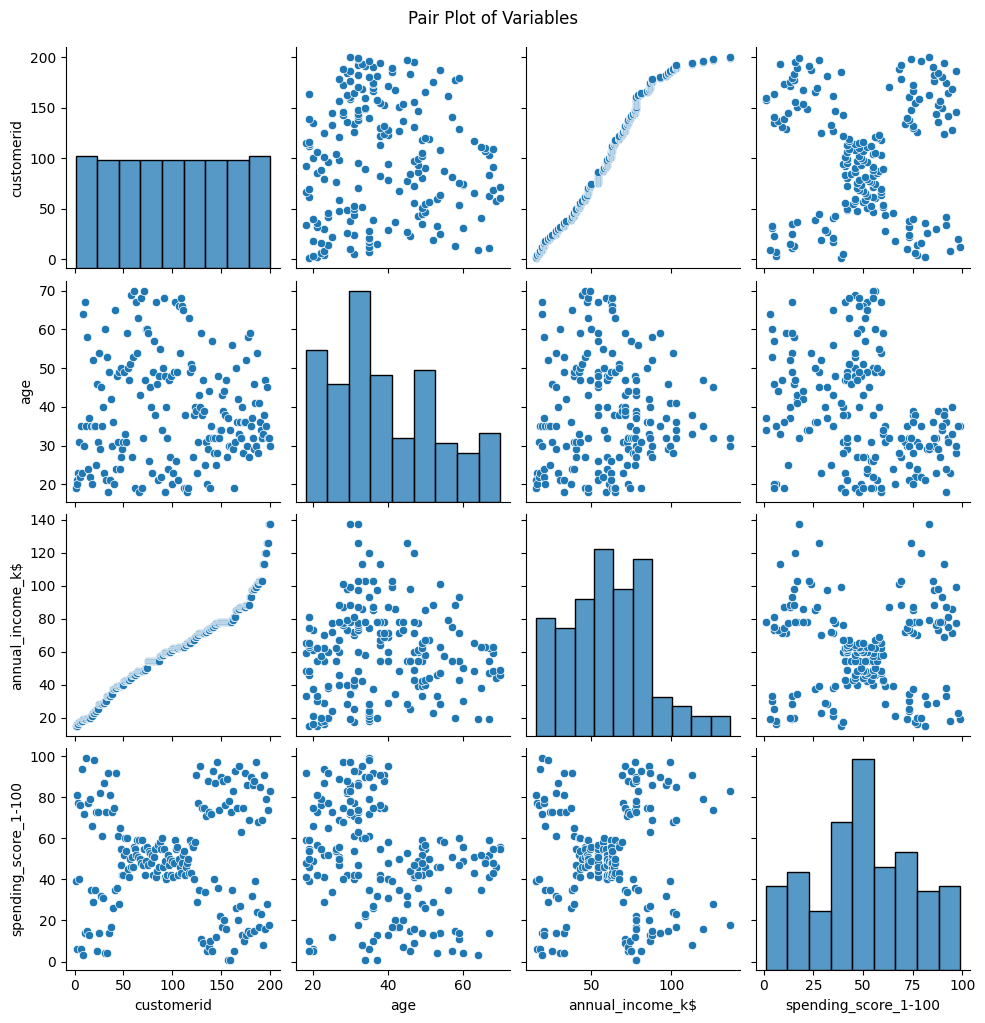

In [8]:
# make pairplot
sns.pairplot(customer_data)
plt.suptitle("Pair Plot of Variables", y=1.02)
plt.show()

#### Insight:
**Cluster formation observation**
- customerid and spending_score_1-100 as well as spending_score_1-100 and annual_income_k$ form five distinct clusters with similar positions.
- this might be possible due to different timeline when the customers were acquired.

- maybe in later times, the economic trend was growing, shown by higher customerids (more recent customers) had higher annual_income_k$. that's why the clustering patterns of customerid and annual_income_k$ with spending_score_1-100 were so similar.
 
- moreover, customerid is just an identifier so it should be still excluded from the clustering features.

**Data distribution observation**  

 With customerid removed, the remaining features have the following data distributions:
- rightly skewed: age and annual_income_k$.
- normally distributed: spending_score_1-100.
- we need to confirm with normality test.

#### D'Agostino Normality Test
- it considers kurtosis for normality calculation.

 `HO`: The data has normal distribution  
 `H1`: The data has abnormal distribution

with p-value < 0.05.

In [14]:
# create normality test function
def dagostino_test(var):
    stat,p_value = stats.normaltest(var)
    print(f"Statistic: {stat}, p-value: {p_value}")
    if p_value < 0.05:
        print("The data is not normally distributed (reject H0).")
    else:
        print("The data is normally distributed (fail to reject H0).")

In [16]:
# Run the D'Agostino test for each variable
for column in customer_data.columns:
    if column != 'gender':
        print(f"\nTesting normality for {column}:")
        dagostino_test(customer_data[column])
    else:
        pass


Testing normality for customerid:
Statistic: 93.37783184830445, p-value: 5.2876347502193975e-21
The data is not normally distributed (reject H0).

Testing normality for age:
Statistic: 15.577514003752057, p-value: 0.00041436762218018206
The data is not normally distributed (reject H0).

Testing normality for annual_income_k$:
Statistic: 3.5109953115353187, p-value: 0.1728212154129815
The data is normally distributed (fail to reject H0).

Testing normality for spending_score_1-100:
Statistic: 16.302230221326983, p-value: 0.0002884135672001835
The data is not normally distributed (reject H0).


#### Insight:
- the result indicates only <u>annual_income_k$</u> has normal distribution since it has p-value = 0.173 which is greater than 0.05.

#### b. Gender vs. Numeric Features

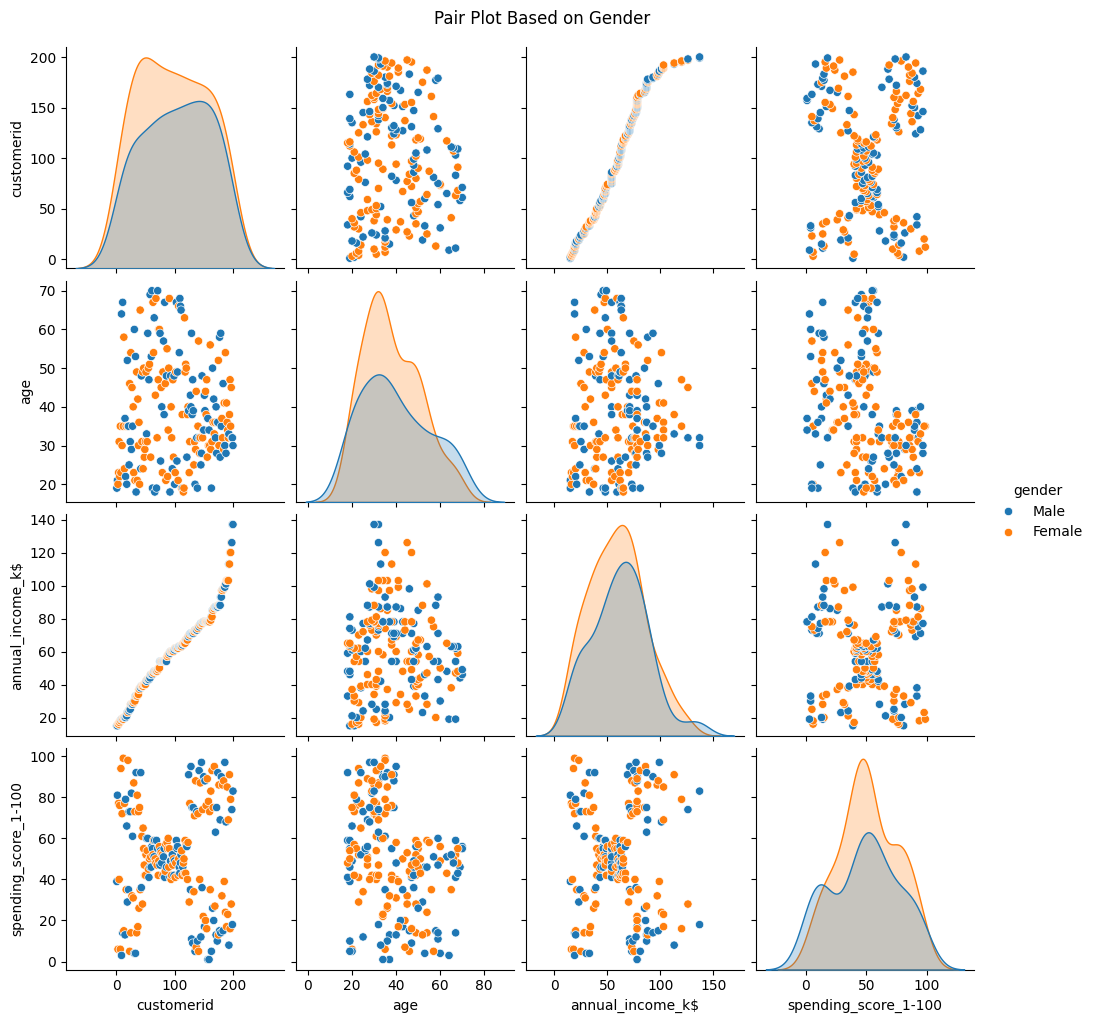

In [12]:
# make pairplot
sns.pairplot(customer_data,hue='gender')
plt.suptitle("Pair Plot Based on Gender", y=1.02)
plt.show()

#### Insight:
- based on the pairplots, we can see that both genders have similar characteristics for each analyzed numerical feature relationship.
- in other words, gender does not significantly influence age, annual income, or spending score for mall customers.
- we can confirm with Mann-Whitney U test.

### 5. Feature Engineering
- perform scaling and PCA
- compare PCA features vs original features.

### 6. Modeling
**Clustering algorithm options**:  

  a. K-Means: simple and easy to interpret with assumption of spherical clusters. It works best with numeric dataset, but gender can be transformed with one-hot encoding. 
    
  b. DBScan: suitable when you expect clusters vary in sizes and shapes.  
   
  c. Gaussian Mixture Model: appropriate when features have different distributions. It's a probabilistic modeling approach.

### 7. Model Evaluation

**Evaluation metrics options**:  

 a. Silhouette Score: measures similarity of a point to its cluster compared to other clusters.  
 - The score range is from -1 to +1. Score near to +1 indicates points are well-clustered.  

 b. Davies-Bouldin Index: measures ratio of average intra-cluster distance to average inter-cluster distance. The smaller, the better the clustering since the separation is more apparent.  
  - <u>intra-cluster distance</u> shows how compact your cluster is (high internal similarity).  
  - <u>inter cluster distance</u> describes how different a cluster compared to another one (high external differentiation).

### 7. Conclusion